# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

### Consolidar Base de Dados

In [2]:
#Set an empty DataFrame
month = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

airbnb_df = pd.DataFrame()
#Set datasets path.
path_data = Path('dataset')
#Iterate all the files in selected path.
for file in path_data.iterdir():
    df = pd.read_csv(path_data / file.name)
    df['month'] = month[file.name[:3]]
    df['year'] = int(file.name[-8:-4])
    airbnb_df = airbnb_df.append(df)

# display(airbnb_df)

/var/folders/4z/8gl0xff175l103wbrd9gd3g00000gn/T/ipykernel_46822/2023909990.py:9: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_data / file.name)
/var/folders/4z/8gl0xff175l103wbrd9gd3g00000gn/T/ipykernel_46822/2023909990.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  airbnb_df = airbnb_df.append(df)
/var/folders/4z/8gl0xff175l103wbrd9gd3g00000gn/T/ipykernel_46822/2023909990.py:9: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_data / file.name)
/var/folders/4z/8gl0xff175l103wbrd9gd3g00000gn/T/ipykernel_46822/2023909990.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  airbnb_df = airbnb_df.append(df)
/var/folders/4z/8gl0xff175l103wbrd9g

In [3]:
airbnb_df.head(1000).to_csv('earliest records.csv')

/Users/franciscojunior/Downloads/airbnb_project/airbnb_project/venvds/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [4]:
columns = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','is_location_exact','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','cancellation_policy','month','year']

airbnb_df = airbnb_df.loc[:, columns]
display(airbnb_df)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,is_location_exact,property_type,room_type,accommodates,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,month,year
0,within an hour,100%,t,2.0,-22.96592,-43.17896,t,Condominium,Entire home/apt,5,...,10.0,10.0,10.0,10.0,10.0,9.0,t,strict_14_with_grace_period,1,2020
1,within an hour,100%,f,0.0,-22.98467,-43.19611,t,Apartment,Entire home/apt,6,...,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,1,2020
2,within a day,86%,f,3.0,-22.97712,-43.19045,t,Apartment,Entire home/apt,2,...,9.0,10.0,9.0,10.0,10.0,9.0,f,strict_14_with_grace_period,1,2020
3,within an hour,100%,t,1.0,-22.98302,-43.21427,t,Apartment,Entire home/apt,3,...,10.0,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,1,2020
4,within an hour,100%,f,1.0,-22.98816,-43.19359,t,Apartment,Entire home/apt,2,...,10.0,9.0,10.0,10.0,10.0,9.0,f,strict_14_with_grace_period,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36373,NaN,NaN,f,1.0,-23.02612,-43.46498,f,Condominium,Entire home/apt,6,...,NaN,NaN,NaN,NaN,NaN,NaN,t,flexible,3,2019
36374,NaN,NaN,f,1.0,-23.01049,-43.36381,t,Apartment,Entire home/apt,6,...,NaN,NaN,NaN,NaN,NaN,NaN,t,flexible,3,2019
36375,NaN,NaN,f,1.0,-22.92795,-43.17568,f,Apartment,Entire home/apt,2,...,NaN,NaN,NaN,NaN,NaN,NaN,t,flexible,3,2019
36376,within a few hours,84%,f,34.0,-22.96248,-43.17447,f,Apartment,Entire home/apt,5,...,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,3,2019


### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

### Handling Missing Values

- Analyzing the data, we can see that there are many empty values. The columns with more than 300,000 NaN values have been eliminated.
- For the other columns, since we still have a lot of data (more than 900,000 rows), we will just discard the NaN data.

In [5]:
for column in airbnb_df:
    if airbnb_df[column].isnull().sum() > 300000:
        airbnb_df = airbnb_df.drop(column, axis=1)

airbnb_df = airbnb_df.dropna()

print(airbnb_df.shape)

(897709, 23)


### Verificar Tipos de Dados em cada coluna

In [6]:
print(airbnb_df.dtypes)
print('-' * 55)
print(airbnb_df.iloc[0])

host_is_superhost       object
host_listings_count    float64
latitude               float64
longitude              float64
is_location_exact       object
property_type           object
room_type               object
accommodates             int64
bathrooms              float64
bedrooms               float64
beds                   float64
bed_type                object
amenities               object
price                   object
guests_included          int64
extra_people            object
minimum_nights           int64
maximum_nights           int64
number_of_reviews        int64
instant_bookable        object
cancellation_policy     object
month                    int64
year                     int64
dtype: object
-------------------------------------------------------
host_is_superhost                                                      t
host_listings_count                                                  2.0
latitude                                                       -22.9659

In [7]:
# column price and extra people --> float
airbnb_df['price'] = airbnb_df['price'].str.replace('$', '')
airbnb_df['price'] = airbnb_df['price'].str.replace(',', '')
airbnb_df['price'] = airbnb_df['price'].astype(np.float32, copy=False)

airbnb_df['extra_people'] = airbnb_df['extra_people'].str.replace('$', '')
airbnb_df['extra_people'] = airbnb_df['extra_people'].str.replace(',', '')
airbnb_df['extra_people'] = airbnb_df['extra_people'].astype(np.float32, copy=False)

print(airbnb_df.dtypes)

/var/folders/4z/8gl0xff175l103wbrd9gd3g00000gn/T/ipykernel_46822/2761241454.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  airbnb_df['price'] = airbnb_df['price'].str.replace('$', '')
/var/folders/4z/8gl0xff175l103wbrd9gd3g00000gn/T/ipykernel_46822/2761241454.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  airbnb_df['extra_people'] = airbnb_df['extra_people'].str.replace('$', '')


host_is_superhost       object
host_listings_count    float64
latitude               float64
longitude              float64
is_location_exact       object
property_type           object
room_type               object
accommodates             int64
bathrooms              float64
bedrooms               float64
beds                   float64
bed_type                object
amenities               object
price                  float32
guests_included          int64
extra_people           float32
minimum_nights           int64
maximum_nights           int64
number_of_reviews        int64
instant_bookable        object
cancellation_policy     object
month                    int64
year                     int64
dtype: object


### Análise Exploratória e Tratar Outliers

/var/folders/4z/8gl0xff175l103wbrd9gd3g00000gn/T/ipykernel_46822/2543745178.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(airbnb_df.corr(), annot=True, cmap='Greens')


<AxesSubplot: >

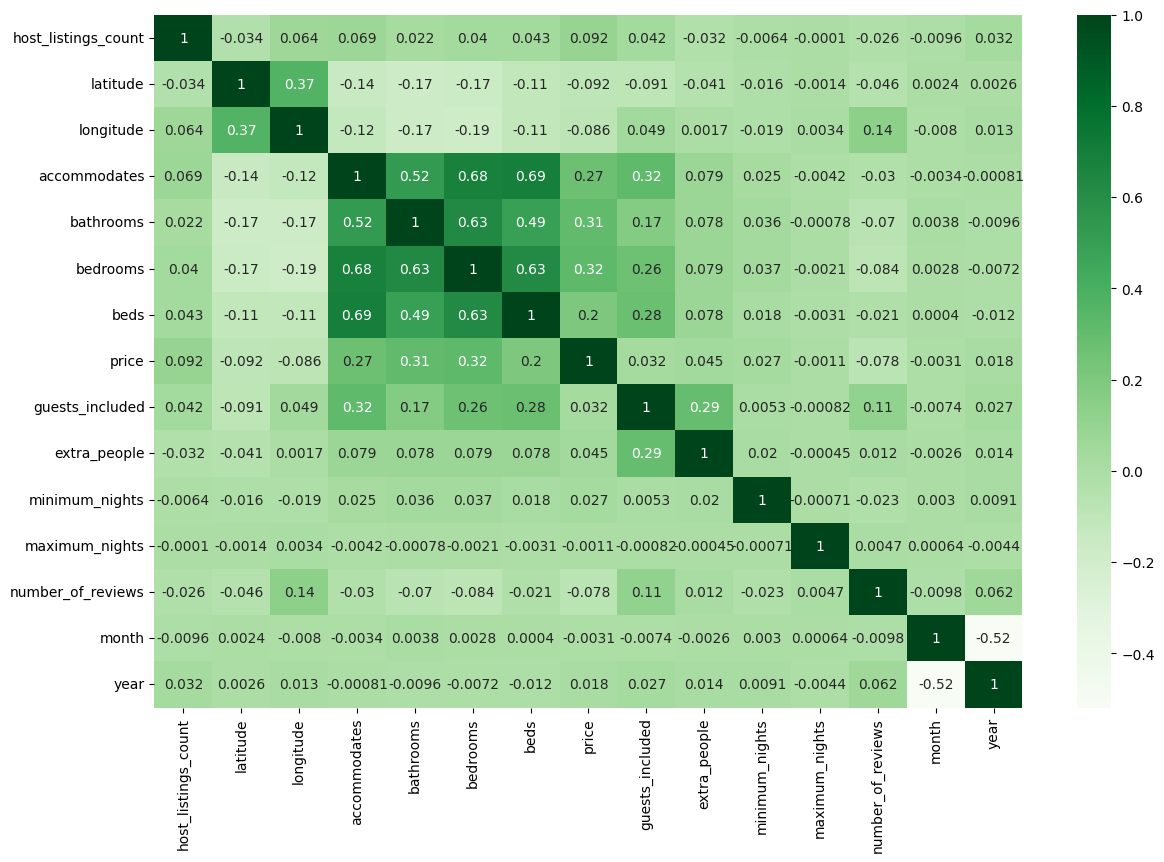

In [8]:
plt.figure(figsize=(14,9))
sns.heatmap(airbnb_df.corr(), annot=True, cmap='Greens')

In [9]:
def limits(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1

    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def del_outliers(df, column):
    rows_qtt = df.shape[0]
    bottom_lim, top_lim = limits(df[column])
    df = df.loc[(df[column] >= bottom_lim) & (df[column] <= top_lim), :]

    return df, rows_qtt - df.shape[0]

In [18]:
def box_diagram(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=column, ax=ax1)
    ax2.set_xlim(limits(column))
    sns.boxplot(x=column, ax=ax2)

def histogram(column):
    plt.figure(figsize=(15,5))
    sns.histplot(column, kde=True, linewidth=0)

def bar_graph(column):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=column.value_counts().index, y=column.value_counts())
    ax.set_xlim(limits(column))

## Price

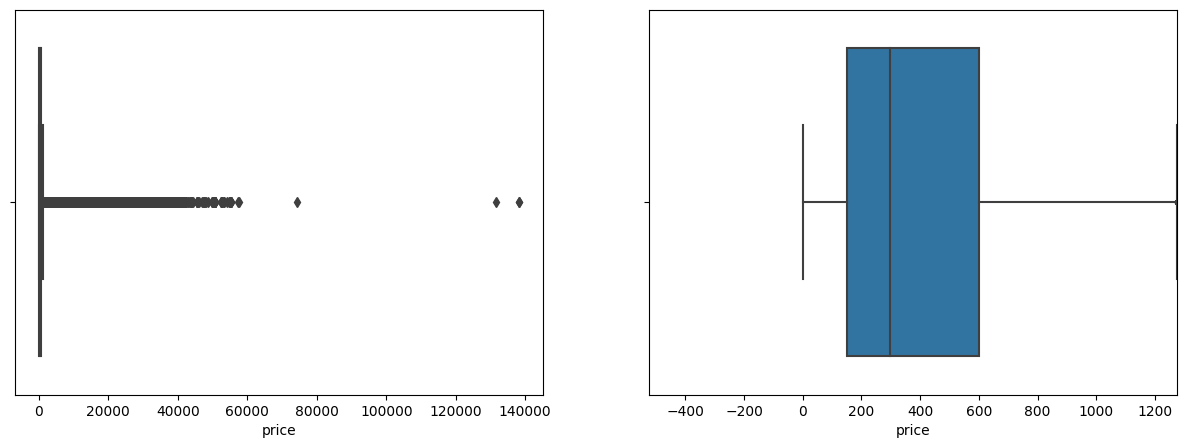

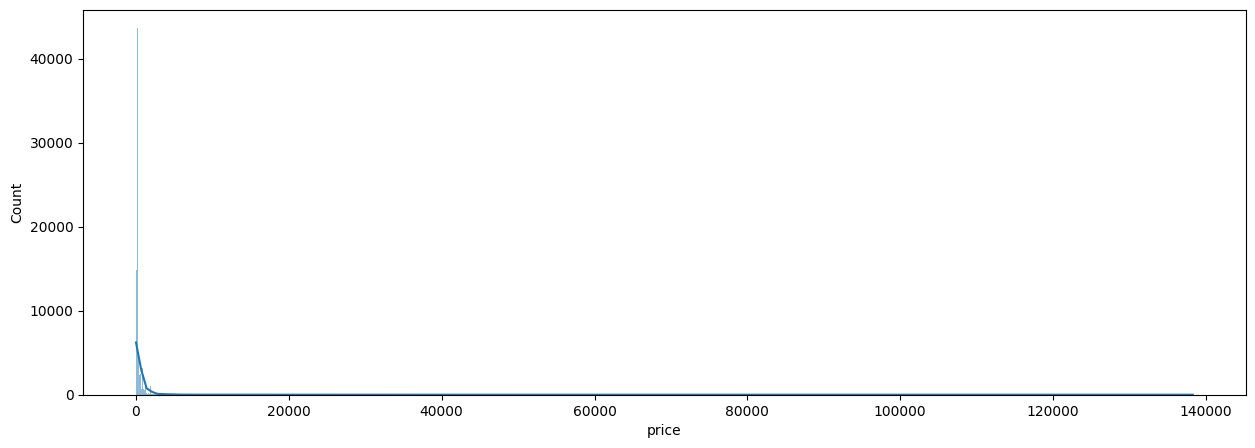

In [11]:
box_diagram(airbnb_df['price'])
histogram(airbnb_df['price'])

In [12]:
airbnb_df, removed_rows = del_outliers(airbnb_df, 'price')
print(f'{removed_rows} Removed rows.')

87282 Removed rows.


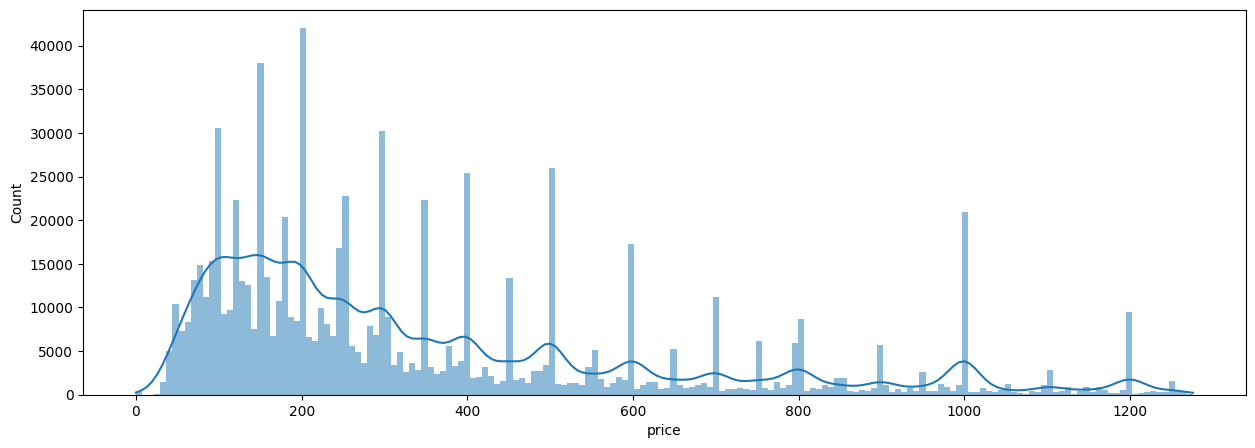

In [13]:
histogram(airbnb_df['price'])

## Extra People

5631.0


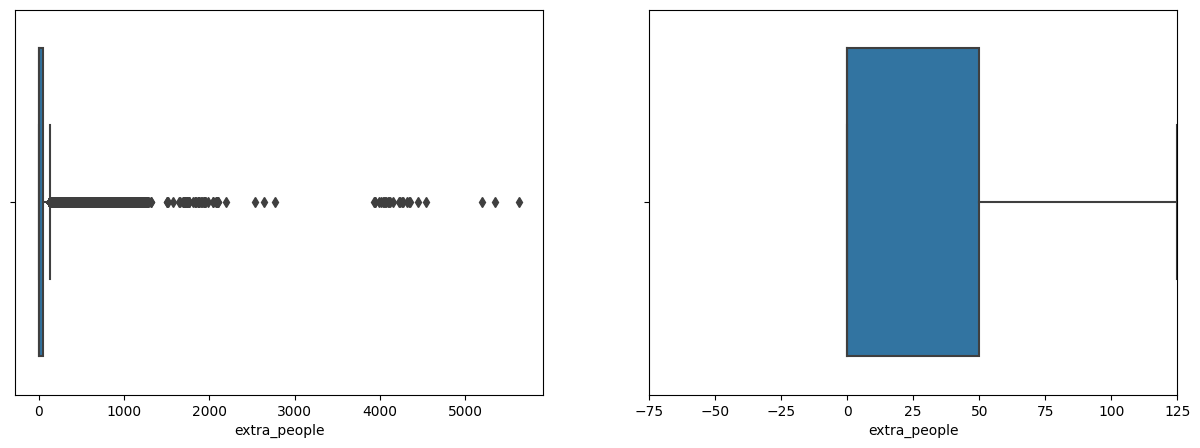

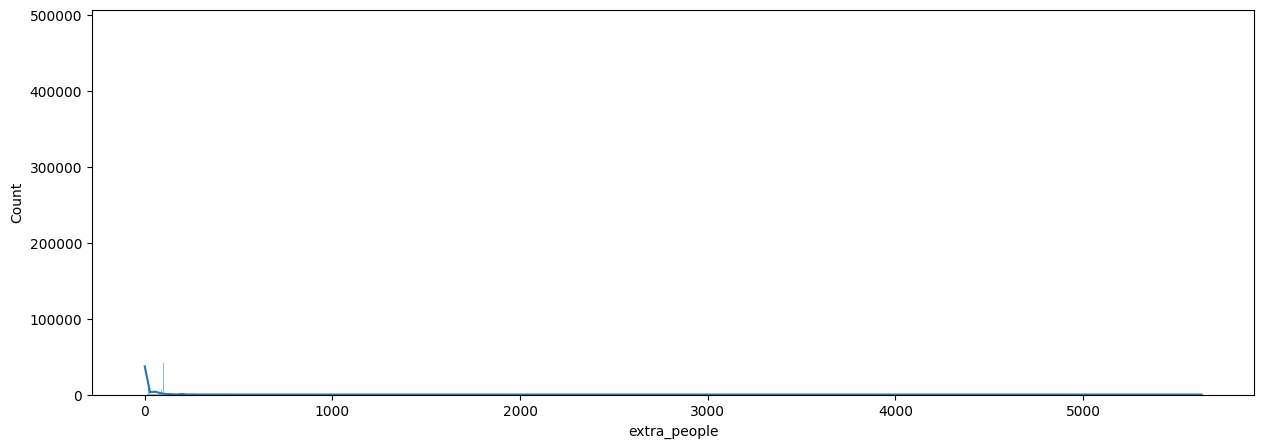

In [14]:
box_diagram(airbnb_df['extra_people'])
histogram(airbnb_df['extra_people'])
print(airbnb_df['extra_people'].max())

In [15]:
airbnb_df, removed_rows = del_outliers(airbnb_df, 'extra_people')
print(f'{removed_rows} Removed rows.')

59194 Removed rows.


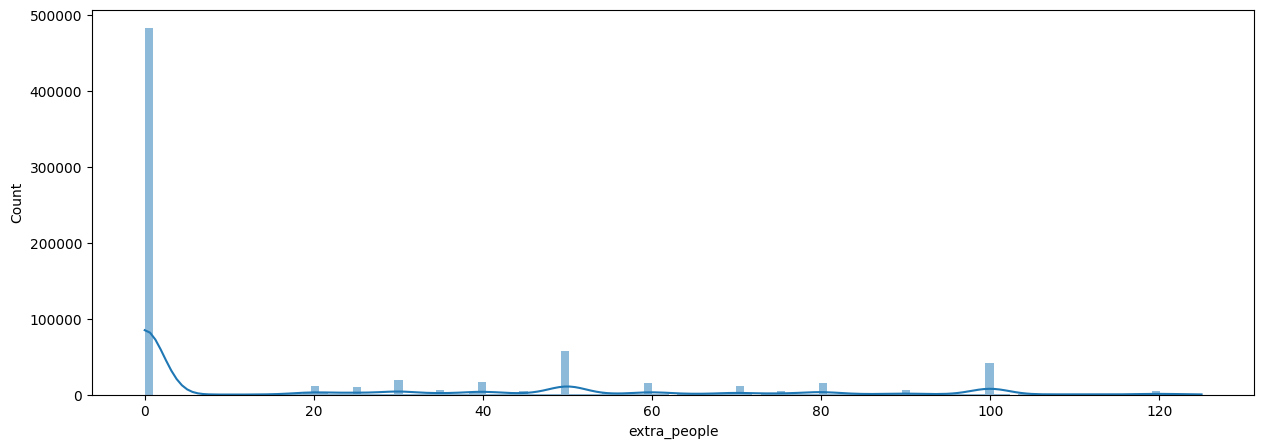

In [17]:
histogram(airbnb_df['extra_people'])


### host_listings_count

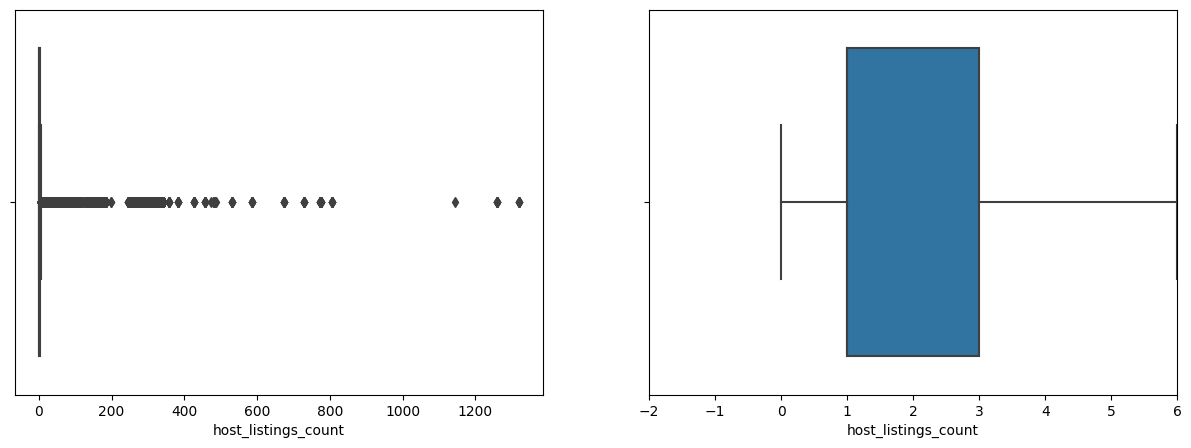

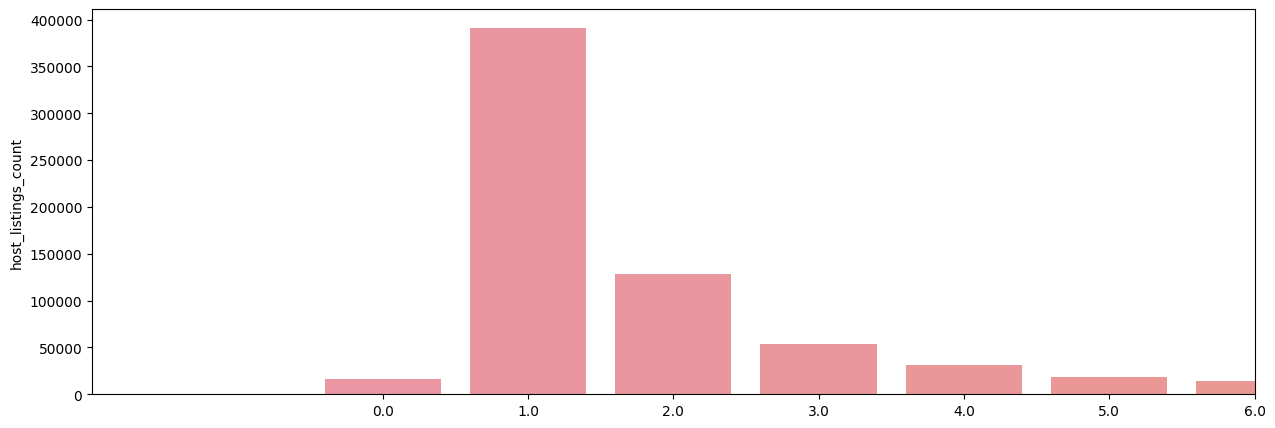

In [19]:
box_diagram(airbnb_df['host_listings_count'])
bar_graph(airbnb_df['host_listings_count'])

In [20]:
airbnb_df, removed_rows = del_outliers(airbnb_df, 'host_listings_count')
print(f'{removed_rows} removed rows')

97723 removed rows


### Accommodates

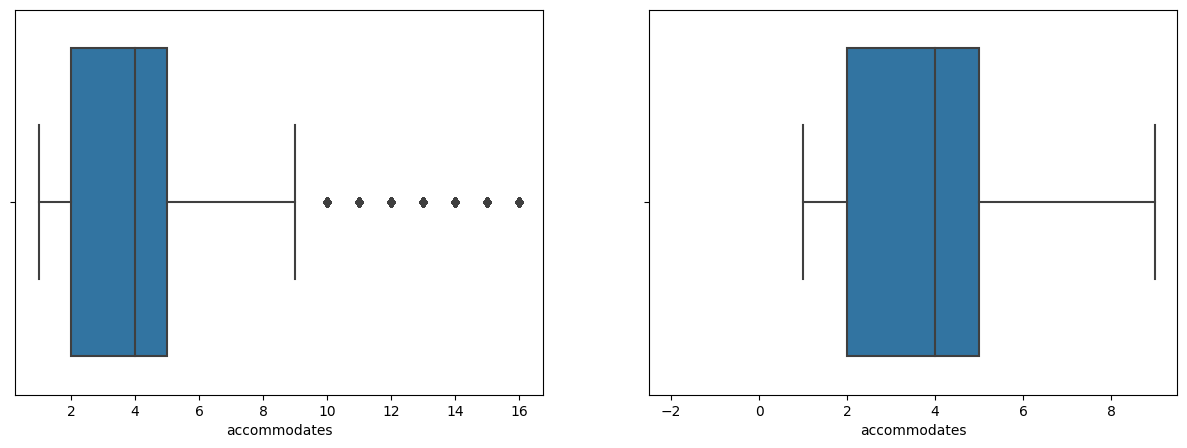

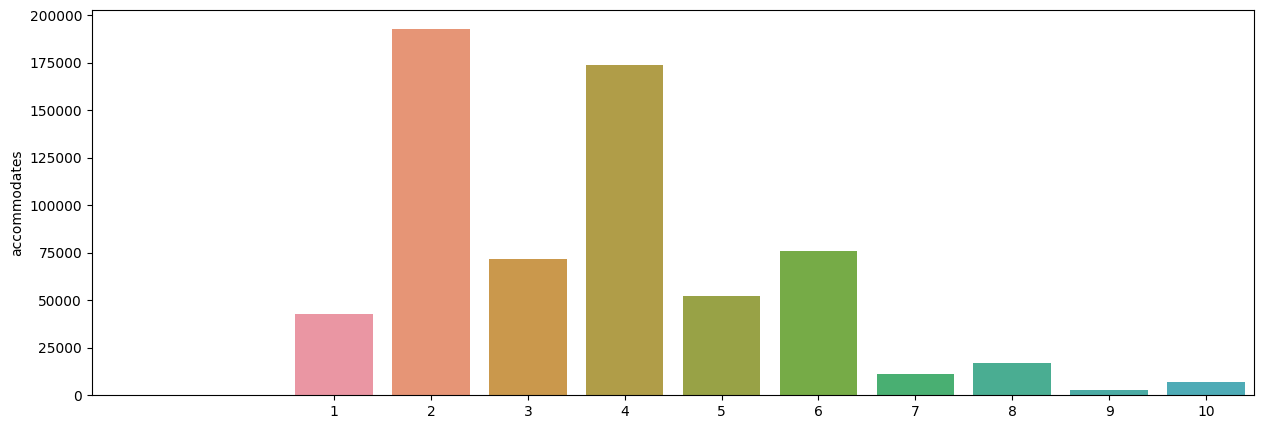

In [21]:
box_diagram(airbnb_df['accommodates'])
bar_graph(airbnb_df['accommodates'])

### Bathrooms

<AxesSubplot: ylabel='bathrooms'>

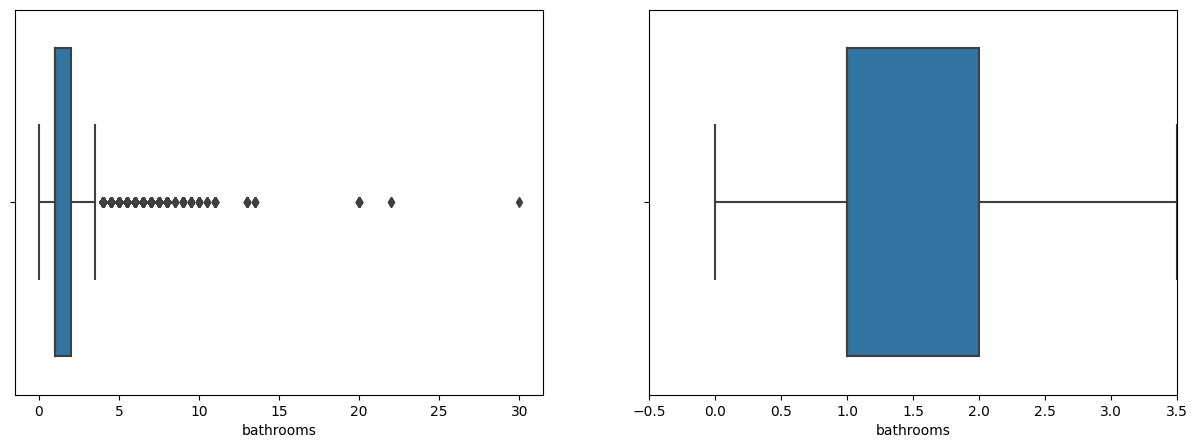

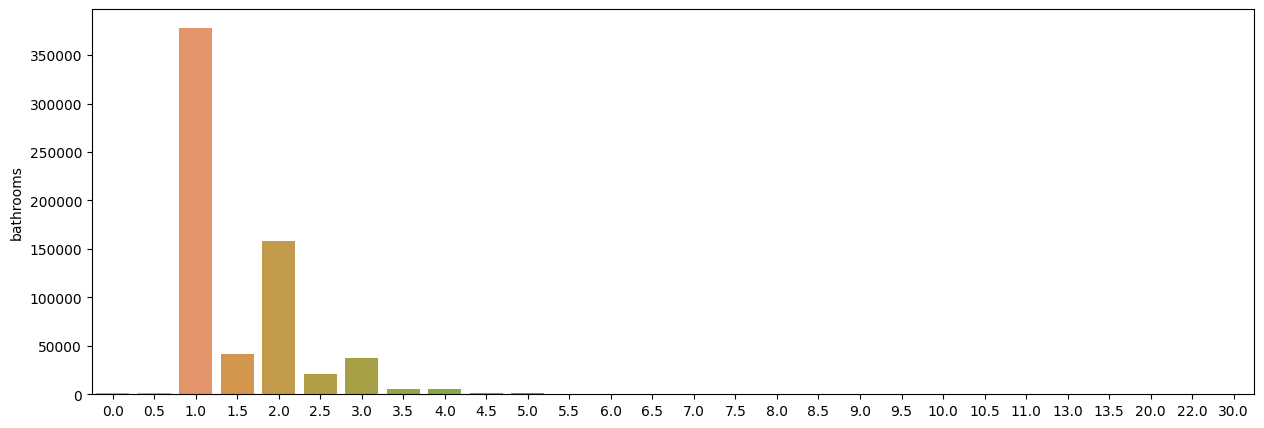

In [23]:
box_diagram(airbnb_df['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=airbnb_df['bathrooms'].value_counts().index, y=airbnb_df['bathrooms'].value_counts())

### Bedrooms

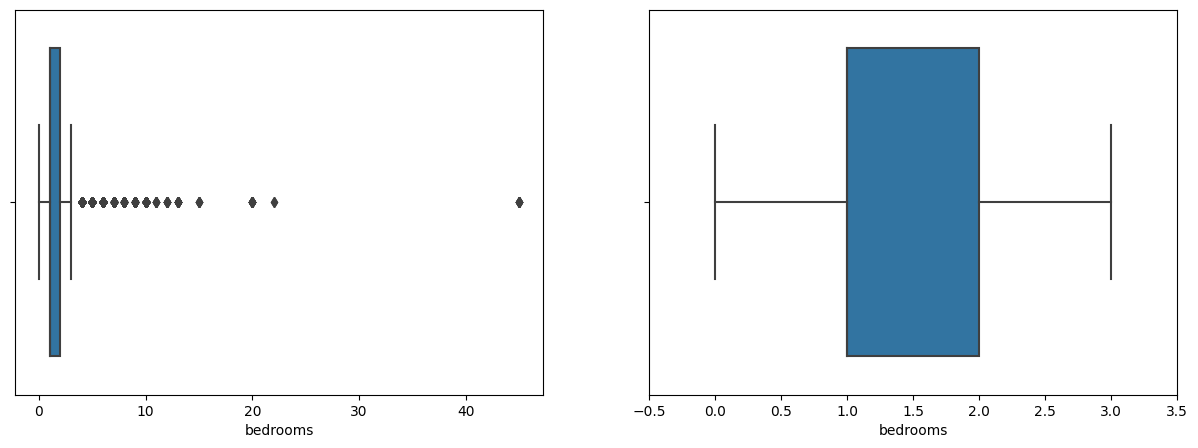

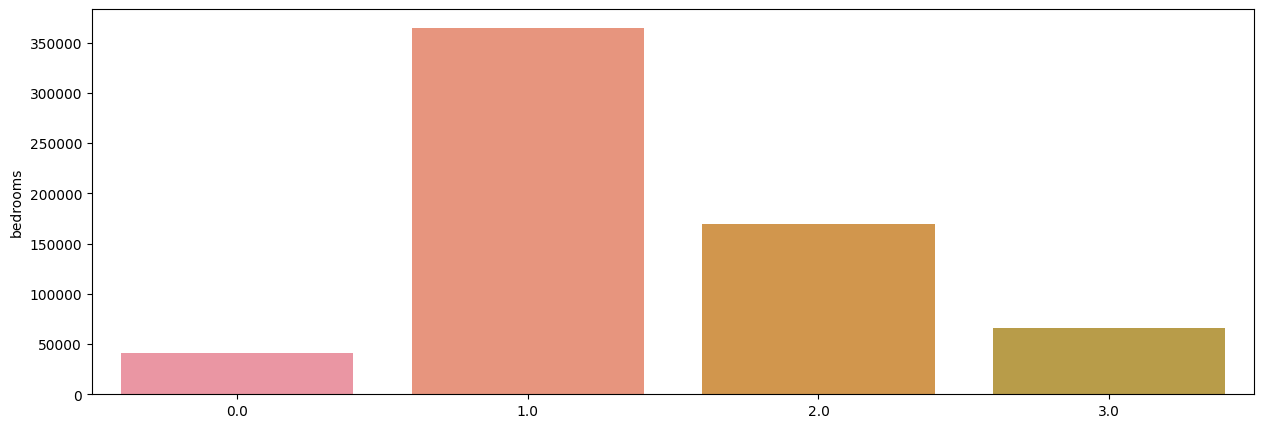

In [24]:
box_diagram(airbnb_df['bedrooms'])
bar_graph(airbnb_df['bedrooms'])

### Beds

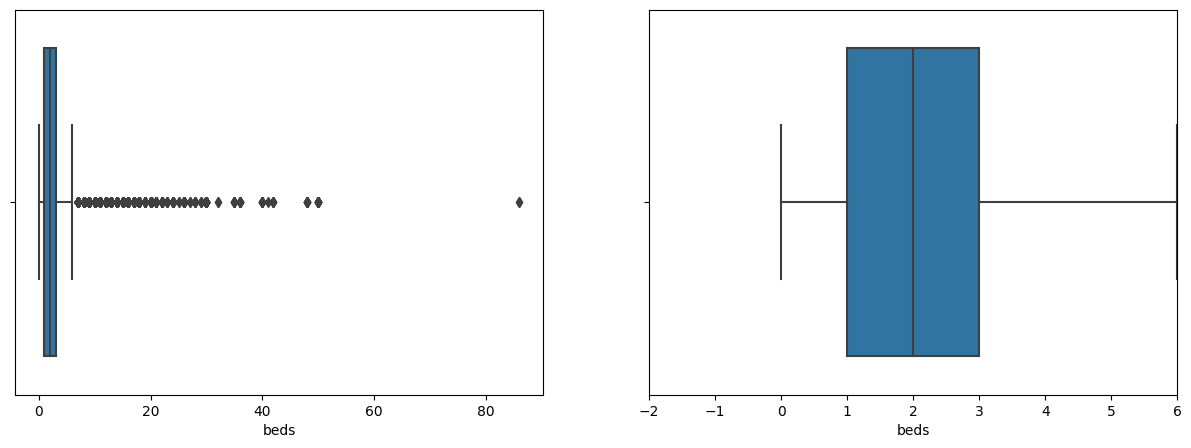

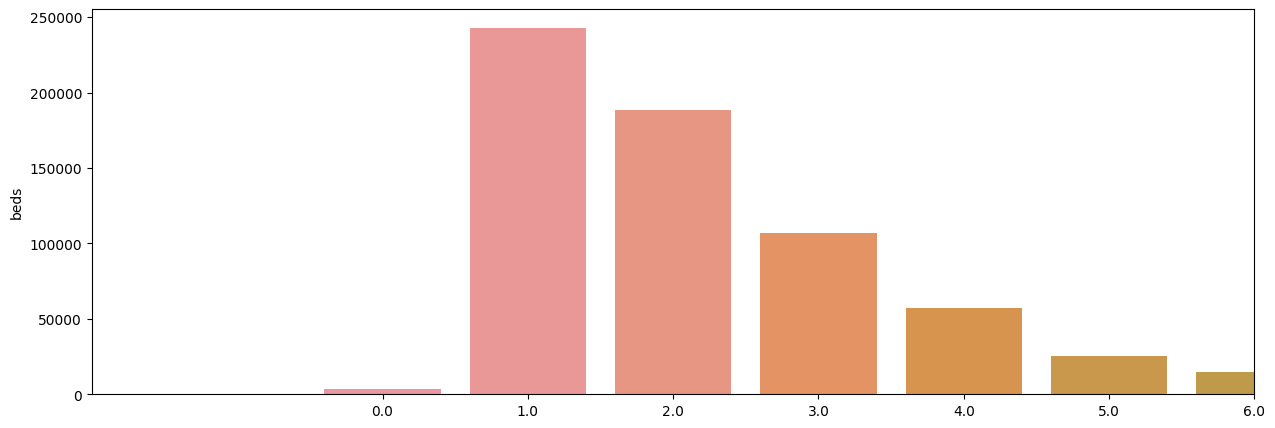

In [25]:
box_diagram(airbnb_df['beds'])
bar_graph(airbnb_df['beds'])

### Encoding

In [16]:
display(airbnb_df)

,host_is_superhost,host_listings_count,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,...,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,cancellation_policy,month,year
0,t,2.0,-22.96592,-43.17896,t,Condominium,Entire home/apt,5,1.0,2.0,...,332.0,2,63.0,5,30,246,t,strict_14_with_grace_period,1,2020
1,f,0.0,-22.98467,-43.19611,t,Apartment,Entire home/apt,6,2.0,2.0,...,336.0,6,0.0,5,30,89,f,strict_14_with_grace_period,1,2020
2,f,3.0,-22.97712,-43.19045,t,Apartment,Entire home/apt,2,1.0,1.0,...,159.0,2,45.0,7,60,237,f,strict_14_with_grace_period,1,2020
3,t,1.0,-22.98302,-43.21427,t,Apartment,Entire home/apt,3,1.0,1.0,...,273.0,2,42.0,2,1125,277,t,strict_14_with_grace_period,1,2020
4,f,1.0,-22.98816,-43.19359,t,Apartment,Entire home/apt,2,1.5,1.0,...,378.0,2,63.0,2,89,174,f,strict_14_with_grace_period,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36372,t,331.0,-22.97174,-43.18507,t,Apartment,Entire home/apt,9,2.5,2.0,...,471.0,1,0.0,3,1125,0,f,strict_14_with_grace_period,3,2019
36373,f,1.0,-23.02612,-43.46498,f,Condominium,Entire home/apt,6,2.5,2.0,...,451.0,1,0.0,3,1125,0,t,flexible,3,2019
36374,f,1.0,-23.01049,-43.36381,t,Apartment,Entire home/apt,6,1.0,1.0,...,272.0,1,0.0,2,60,0,t,flexible,3,2019
36376,f,34.0,-22.96248,-43.17447,f,Apartment,Entire home/apt,5,1.0,1.0,...,199.0,1,0.0,2,25,0,f,flexible,3,2019


### Modelo de Previsão

### Análise do Melhor Modelo

### Ajustes e Melhorias no Melhor Modelo